In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports 

In [31]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt 
import time
import math

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils as tu

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
# GPU testing 
torch.backends.cuda.is_built()

False

In [8]:
file = '../input/mouse-mri-test/test_rep/test_rep/3nt6a_1N_rep1.nii'
file2 = '../input/mouse-mri-test/test_corrected/test_corrected/3nt6a_1N_pre_WH_N4corrected.nii'
img = nib.load(file)
img2 = nib.load(file2)

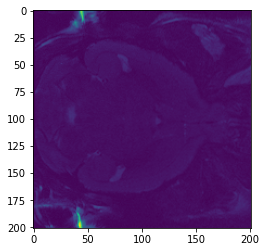

In [10]:
data1 = img.get_fdata()
data2 = img2.get_fdata()
plt.imshow(data2[:, :, 10])

In [38]:
data1.shape

(201, 201, 18)

# Data Preparation

In [13]:
class Dataset (object):
    
""" an abstract class representing a dataset.
all other datasets should subclass it. all subclasses should override
`` __len__``, that provides the size of the dataset, and `` __getitem__``,supporting integer indexing in range from 0 to len (self) exclusive.
"""
    def __getitem __ (self, index):
     raise notimplementederror
    def __len __ (self):
     raise notimplementederror
    def __add __ (self, other):
     return concatdataset ([self, other])

IndentationError: expected an indented block (<ipython-input-13-0f1ee37b1779>, line 5)

In [8]:
class Mouse_mri_dataset(tu.data.Dataset):
    """Custom Dataset Class to handle NIFTI files
    arguments : 
    
    """
    
    def __init__(self, data_path, gt_path, transform=None):
        
        self.data_path = data_path
        self.gt_path = gt_path
        self.transform = transform 
        self.data_file_names = os.listdir(self.data_path)
        self.gt_file_names = os.listdir(self.gt_path)
        self.data_file_names.sort()
        self.gt_file_names.sort()
        
        self.data_nii_files = []
        self.gt_nii_files = []
        
        for count, img_name in enumerate(self.data_file_names) :
            self.data_nii_files.append(os.path.join(self.data_path, img_name))
            self.gt_nii_files.append(os.path.join(self.gt_path, self.gt_file_names[count//4]))
            
    def __getitem__(self, index):
        data_img_file = self.data_nii_files[index]
        gt_img_file = self.gt_nii_files[index//4]
        
        name_img_sample = self.data_file_names[index]
        gt_name_sample = self.gt_file_names[index//4]
        
        data_img_nib = nib.load(data_img_file)
        gt_img_nib = nib.load(gt_img_file)
        
        data_img = data_img_nib.get_fdata()
        gt_img = data_img_nib.get_fdata()
        
        img_tens = torch.from_numpy (data_img)
        gt_tens = torch.from_numpy (gt_img)
        
        #img_tensor = img_tens.type(torch.tensor)
        #gt_tensor = gt_tens.type(torch.tensor)
        
        sample = {'img': img_tens, 'gt': gt_tens, 'img_name': name_img_sample
                 , 'gt_name':gt_name_sample}
        
        if self.transform:
            sample = self.transform(sample)
        
        return(sample)
                        
    def __len__(self):
        return(len(self.data_nii_files))
        
    

In [19]:
data_path_mri = '../input/mouse-mri-test/test_rep/test_rep/'
gt_path_mri = '../input/mouse-mri-test/test_corrected/test_corrected'
mri_dataset = Mouse_mri_dataset(data_path=data_path_mri, gt_path = gt_path_mri)

print(len(mri_dataset))
print(mri_dataset[1]['img'].shape, mri_dataset[1]['gt'].shape )

400
torch.Size([201, 201, 18]) torch.Size([201, 201, 18])


5 torch.Size([201, 201, 18]) 20190322_182907_20190322_TN_APOETau_4NT40a_4_1_1_rep2.nii torch.Size([201, 201, 18]) 20190322_182907_20190322_TN_APOETau_4NT40a_4_1_1_pre_WH_N4corrected.nii
6 torch.Size([201, 201, 18]) 20190322_182907_20190322_TN_APOETau_4NT40a_4_1_1_rep3.nii torch.Size([201, 201, 18]) 20190322_182907_20190322_TN_APOETau_4NT40a_4_1_1_pre_WH_N4corrected.nii
7 torch.Size([201, 201, 18]) 20190322_182907_20190322_TN_APOETau_4NT40a_4_1_1_rep4.nii torch.Size([201, 201, 18]) 20190322_182907_20190322_TN_APOETau_4NT40a_4_1_1_pre_WH_N4corrected.nii
8 torch.Size([201, 201, 18]) 20190324_173423_20190324_TN_APOETau_4NT38a_3_1_1_rep1.nii torch.Size([201, 201, 18]) 20190324_173423_20190324_TN_APOETau_4NT38a_3_1_1_pre_WH_N4corrected.nii


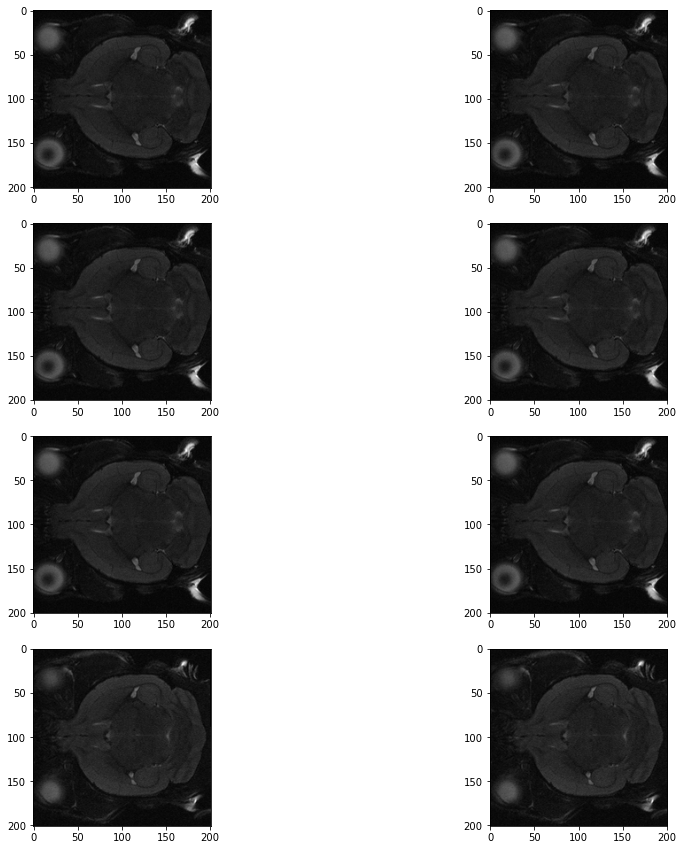

In [10]:
idx = 5
fig = plt.figure()
axes = []
for i in range (4):
    sample = mri_dataset[idx+i]
    print(idx+i, sample['img'].shape, sample['img_name'],
         sample['gt'].shape, sample['gt_name'])
    axes.append(fig.add_subplot(4, 2, (2*i)+1))
    plt.imshow(sample['img'][:,:,9], cmap='gray')
    axes.append(fig.add_subplot(4, 2, (2*i+1)+1))
    plt.imshow(sample['gt'][:,:,9], cmap='gray')
#fig.tight_layout() 
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show()

## Data split

In [98]:
train_dataset, val_dataset, test_dataset = tu.data.random_split(mri_dataset, [280, 60, 60],
                                                                generator=torch.Generator().manual_seed(42))

print('train set size =',len(train_dataset))
print('validation set size =', len(val_dataset))
print('test set size =', len(test_dataset))

train_loader = tu.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True)
val_loader = tu.data.DataLoader(val_dataset, batch_size=32,
                                          shuffle=True)
test_loader = tu.data.DataLoader(test_dataset, batch_size=32,
                                         shuffle=True)

train set size = 280
validation set size = 60
test set size = 60


In [93]:
x, y, z = tu.data.random_split(range(10), [2, 5, 3], generator=torch.Generator().manual_seed(42))
print(x)

In [35]:
names_data = os.listdir('../input/mouse-mri-test/test_rep/test_rep/') 
names_gt = os.listdir('../input/mouse-mri-test/test_corrected/test_corrected') 
names_data.sort()
names_gt.sort()

# NN Model 

In [6]:
class ResAttU_Net3D(nn.Module):
    def __init__(self, UnetLayer=5, img_ch = 1, output_ch = 1, first_layer_numKernel = 6):
        super(ResAttU_Net3D, self).__init__()

        self.UnetLayer = UnetLayer
        self.Maxpool = nn.MaxPool3d(kernel_size = 2, stride = 2)

        self.Conv1 = resconv_block_3D(ch_in = img_ch, ch_out = first_layer_numKernel)
        self.Conv2 = resconv_block_3D(ch_in = first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        self.Conv3 = resconv_block_3D(ch_in = 2 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        self.Conv4 = resconv_block_3D(ch_in = 4 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)
        self.Conv5 = resconv_block_3D(ch_in = 8 * first_layer_numKernel, ch_out = 16 * first_layer_numKernel)
        self.Conv6 = resconv_block_3D(ch_in = 16 * first_layer_numKernel, ch_out = 32 * first_layer_numKernel)
        self.Conv7 = resconv_block_3D(ch_in = 32 * first_layer_numKernel, ch_out = 64 * first_layer_numKernel)

        self.Up7 = up_conv_3D(ch_in = 64 * first_layer_numKernel, ch_out = 32 * first_layer_numKernel)
        self.Att7 = Attention_block_3D(F_g = 32 * first_layer_numKernel, F_l = 32 * first_layer_numKernel, F_int = 16 * first_layer_numKernel)
        self.Up_conv7 = resconv_block_3D(ch_in = 64 * first_layer_numKernel, ch_out = 32 * first_layer_numKernel)

        self.Up6 = up_conv_3D(ch_in = 32 * first_layer_numKernel, ch_out = 16 * first_layer_numKernel)
        self.Att6 = Attention_block_3D(F_g = 16 * first_layer_numKernel, F_l = 16 * first_layer_numKernel, F_int = 8 * first_layer_numKernel)
        self.Up_conv6 = resconv_block_3D(ch_in = 32 * first_layer_numKernel, ch_out = 16 * first_layer_numKernel)

        self.Up5 = up_conv_3D(ch_in = 16 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)
        self.Att5 = Attention_block_3D(F_g = 8 * first_layer_numKernel, F_l = 8 * first_layer_numKernel, F_int = 4 * first_layer_numKernel)
        self.Up_conv5 = resconv_block_3D(ch_in = 16 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)

        self.Up4 = up_conv_3D(ch_in = 8 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        self.Att4 = Attention_block_3D(F_g = 4 * first_layer_numKernel, F_l = 4* first_layer_numKernel, F_int = 2 * first_layer_numKernel)
        self.Up_conv4 = resconv_block_3D(ch_in = 8 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        
        self.Up3 = up_conv_3D(ch_in = 4 * first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        self.Att3 = Attention_block_3D(F_g = 2 * first_layer_numKernel, F_l = 2 * first_layer_numKernel, F_int = first_layer_numKernel)
        self.Up_conv3 = resconv_block_3D(ch_in = 4 * first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        
        self.Up2 = up_conv_3D(ch_in = 2 * first_layer_numKernel, ch_out = first_layer_numKernel)
        self.Att2 = Attention_block_3D(F_g = first_layer_numKernel, F_l = first_layer_numKernel, F_int = int(first_layer_numKernel / 2))
        self.Up_conv2 = resconv_block_3D(ch_in = 2 * first_layer_numKernel, ch_out = first_layer_numKernel)

        self.Conv_1x1 = nn.Conv3d(first_layer_numKernel, output_ch, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)
        
        d3 = self.Up3(x3)

        if self.UnetLayer > 3:    
            x4 = self.Maxpool(x3)
            x4 = self.Conv4(x4)

            d4 = self.Up4(x4)

            if self.UnetLayer > 4:
                x5 = self.Maxpool(x4)
                x5 = self.Conv5(x5)

                d5 = self.Up5(x5)

                if self.UnetLayer > 5:
                    x6 = self.Maxpool(x5)
                    x6 = self.Conv6(x6)

                    d6 = self.Up6(x6)

                    if self.UnetLayer > 6:
                        x7 = self.Maxpool(x6)
                        x7 = self.Conv7(x7)

                        d7 = self.Up7(x7)
                        x6 = self.Att7(g = d7, x = x6)
                        d7 = torch.cat((x6, d7), dim = 1)
                        d7 = self.Up_conv7(d7)

                        d6 = self.Up6(d7)

                    x5 = self.Att6(g = d6, x = x5)
                    d6 = torch.cat((x5, d6), dim = 1)        
                    d6 = self.Up_conv6(d6)

                    d5 = self.Up5(d6)

                #d5 = self.Up5(x5) ## Uncomment this for the "wrong_model".
                x4 = self.Att5(g = d5, x = x4)
                d5 = torch.cat((x4, d5), dim = 1)        
                d5 = self.Up_conv5(d5)

                d4 = self.Up4(d5)

            x3 = self.Att4(g = d4, x = x3)
            d4 = torch.cat((x3, d4), dim = 1)
            d4 = self.Up_conv4(d4)

            d3 = self.Up3(d4)
        x2 = self.Att3(g = d3, x = x2)
        d3 = torch.cat((x2, d3), dim = 1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g = d2, x = x1)
        d2 = torch.cat((x1, d2), dim = 1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

# Loss Functions

Loss functions used : L1, SSIM, L1-SSIM mixture

# SSIM 

In [33]:
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    """
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()
    """
    height, width = img1.size()
    channels = 1
    
    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
        
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret


In [1]:
idx_loss = np.random.randint(0,len(mri_dataset))
sample_loss = mri_dataset[idx_loss]
img_loss, gt_loss = sample_loss['img'][:, :, 9], sample_loss['gt'][:, :, 9]
img_loss.shape
ssim_score = ssim(img_loss, gt_loss, 255, window_size=11, window=None, size_average=True, full=False)
print(ssim_score)

NameError: name 'np' is not defined

In [1]:
window

NameError: name 'window' is not defined

# Hyperparameters

In [ ]:
lr = 
optimizer = 


# Model Training L1 